# Data Process

In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import random

In [2]:
import pandas as pd
data= pd.read_pickle('/Users/guyanwu/Downloads/day_data_all.pkl')
df_feature = pd.read_pickle('/Volumes/WDSN570/df_feature_clean_v4.pkl')

In [40]:
dates_iloc = []
for i in ['17'+str(i).zfill(2) for i in range(3, 13)] + \
         ['18'+str(i).zfill(2) for i in range(1, 13)] + \
         ['19'+str(i).zfill(2) for i in range(1, 13)] + \
         ['20'+str(i).zfill(2) for i in range(1, 13)] + \
         ['2101', '2102', '2103']:
    dates_iloc.append(df_feature[df_feature['date'].astype(str).str.startswith('20'+i)].index[0])
dates_iloc.append(df_feature.shape[0])
train_len = dates_iloc[0]

In [4]:
alpha_list = list(df_feature.columns)[10:-2]

# Functino Definition

In [5]:
def l_bin(x, y, w):
    z = np.dot(x, w)
    return np.log(1+np.exp(-y*z)).mean()

def l_bin_grad(x, y, w):
    z = np.dot(x, w)
    g = np.dot(-y * np.exp(-y*z) / (1+np.exp(-y*z)), x) / x.shape[0]
    return g

def l_mul(x, y, w):
    z = np.array([np.dot(x, w[i*11:(i+1)*11]) for i in range(6)])
    return (np.log(np.exp(z).sum(axis=0)) - z[y, np.arange(z.shape[1])]).mean()

def l_mul_grad(x, y, w):
    z = np.array([np.dot(x, w[i*11:(i+1)*11]) for i in range(6)])
    ez = np.exp(z).sum(axis=0)
    g = np.dot((np.exp(z) / ez), x)
    for i in range(6):
        g[i] -= x[y==i].sum(axis=0)
    return g.reshape(-1)

In [22]:
def GD(train_set_x, train_set_y, w, _type, learning_rate = 1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        for data_x, data_y in zip(train_set_x, train_set_y):
            # l = loss(data_x, data_y, w)
            g = grad(data_x, data_y, w)
            w -= learning_rate * g
            if np.linalg.norm(w) > 10:
                w = w /  np.linalg.norm(w) * 10
    return w

In [23]:
def MBGD(train_set_x, train_set_y, w, _type, batch_size=64, learning_rate=1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        rand_index = random.sample(range(train_set_x.shape[0]), batch_size)
        data_x = train_set_x[rand_index]
        data_y = train_set_y[rand_index]
        # l = loss(data_x, data_y, w)
        g = grad(data_x, data_y, w)
        w -= learning_rate * g
        if np.linalg.norm(w) > 10:
            w = w /  np.linalg.norm(w) * 10
    return w

In [24]:
def SGDM(train_set_x, train_set_y, w, _type, beta=0.6, batch_size=64, learning_rate=1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    record_v = w.copy() * 0
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        rand_index = random.sample(range(train_set_x.shape[0]), batch_size)
        data_x = train_set_x[rand_index]
        data_y = train_set_y[rand_index]
        # l = loss(data_x, data_y, w)
        g = grad(data_x, data_y, w)
        v = beta * record_v + (1-beta) * g
        record_v = v.copy()
        w -= learning_rate * v
        if np.linalg.norm(w) > 10:
            w = w /  np.linalg.norm(w) * 10
    return w

In [25]:
def NAG(train_set_x, train_set_y, w, _type, beta=0.6, batch_size=64, learning_rate=1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    record_v = w.copy() * 0
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        rand_index = random.sample(range(train_set_x.shape[0]), batch_size)
        data_x = train_set_x[rand_index]
        data_y = train_set_y[rand_index]
        # l = loss(data_x, data_y, w)
        g = grad(data_x, data_y, w - beta * record_v)
        v = beta * record_v + learning_rate * g
        record_v = v.copy()
        w -= v
        if np.linalg.norm(w) > 10:
            w = w /  np.linalg.norm(w) * 10
    return w

In [26]:
def AdaGrad(train_set_x, train_set_y, w, _type, batch_size=64, learning_rate=1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    r = 0
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        rand_index = random.sample(range(train_set_x.shape[0]), batch_size)
        data_x = train_set_x[rand_index]
        data_y = train_set_y[rand_index]
        g = grad(data_x, data_y, w)
        r += np.linalg.norm(g)**2
        w -= learning_rate * g / (np.sqrt(r) + 1e-8)
        if np.linalg.norm(w) > 10:
            w = w /  np.linalg.norm(w) * 10
    return w

In [27]:
def Adam(train_set_x, train_set_y, w, _type, beta1=0.8, beta2=0.8, batch_size=64, learning_rate=1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    m_record = w.copy() * 0
    v_record = 0
    iteration = 1
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        rand_index = random.sample(range(train_set_x.shape[0]), batch_size)
        data_x = train_set_x[rand_index]
        data_y = train_set_y[rand_index]
        g = grad(data_x, data_y, w)
        m = beta1 * m_record + (1-beta1) * g
        v = beta2 * v_record + (1-beta2) * np.linalg.norm(g)**2
        m_record = m.copy()
        v_record = v
        w -= m / (1 - beta1 ** (iteration)) * learning_rate / np.sqrt(v / (1 - beta2 ** (iteration)) + 1e-8)
        if np.linalg.norm(w) > 10:
            w = w /  np.linalg.norm(w) * 10
        iteration += 1
    return w

In [28]:
def ONS(train_set_x, train_set_y, w, _type, epsilon=0.1, batch_size=64, learning_rate=1e-4):
    if _type == 'bin':
        grad = l_bin_grad
    elif _type == 'mul':
        grad = l_mul_grad
    else:
        raise ValueError('type must be bin or mul')
    start_time = datetime.datetime.now()
    A = np.eye(w.shape[0]) * epsilon
    A_inv = np.eye(w.shape[0]) / epsilon
    while datetime.datetime.now() - start_time < datetime.timedelta(seconds=300):
        rand_index = random.sample(range(train_set_x.shape[0]), batch_size)
        data_x = train_set_x[rand_index]
        data_y = train_set_y[rand_index]
        g = grad(data_x, data_y, w)
        A += np.outer(g, g)
        A_inv -= np.outer(A_inv.dot(g), A_inv.dot(g)) / (1 + g.dot(A_inv).dot(g))
        w -= learning_rate * A_inv.dot(g)
        # if np.linalg.norm(w) > 10:
        #     w = w /  np.linalg.norm(w) * 10
    return w

# main

# Test part

In [42]:
dates_iloc[12]

543498

In [43]:
df_feature[dates_iloc[12]:].head(10)

,date,ticker,high,open_,low,close_,volume,vwap,value,ret,...,alpha60,alpha61,alpha62,alpha63,alpha64,alpha65,alpha67,alpha68,return_bin,return_mul
543498,20180301,000001,12.15,11.92,11.90,12.04,886957.18,12.0564,1069354.491,0.000839,...,-0.585974,1.349535,1.348013,-0.193306,-0.305559,-0.539502,-0.824170,1.515700,-1.0,2
543499,20180301,000002,33.09,32.17,32.02,32.41,336064.32,32.5038,1092337.514,0.015313,...,-1.056775,2.093428,1.952969,-0.731041,-0.311756,-0.586503,-0.530224,2.449666,1.0,4
543500,20180301,000004,20.98,20.55,20.30,20.79,4877.65,20.8032,10147.098,0.020163,...,0.977481,-1.310026,-1.857542,0.703936,1.314979,0.229161,0.678537,-1.451191,1.0,4
543501,20180301,000005,3.84,3.80,3.78,3.83,24567.65,3.8207,9386.441,0.005236,...,1.482977,-0.998580,-0.748776,-0.060791,0.617939,-0.876743,2.244473,-1.050600,1.0,3
543502,20180301,000008,7.58,7.54,7.49,7.52,113348.78,7.5252,85297.795,0.010638,...,-0.500777,0.937980,0.745381,-1.177845,0.404036,1.033795,0.877007,0.296376,1.0,3
543503,20180301,000009,6.16,5.99,5.97,6.09,197971.34,6.0808,120382.168,-0.008264,...,0.467387,0.258142,0.403388,-0.346549,-0.516037,0.898998,-0.929080,-0.205721,-1.0,1
543504,20180301,000010,4.47,4.34,4.33,4.44,86662.45,4.4220,38321.821,0.065760,...,1.456599,-0.836180,-0.864865,1.373935,0.584343,-0.088120,0.729471,-0.660001,1.0,4
543505,20180301,000011,15.60,15.50,15.32,15.51,22884.68,15.5046,35481.707,0.019481,...,0.526226,-0.438119,-0.559121,-0.146027,1.029408,0.395054,-0.043065,-1.036369,1.0,4
543506,20180301,000012,8.06,7.99,7.95,8.00,124188.10,8.0024,99380.379,-0.003769,...,0.649684,-0.829231,-0.385150,-0.364589,0.992934,0.021693,0.602653,-0.472876,-1.0,2
543507,20180301,000014,10.60,10.60,10.40,10.50,29176.02,10.4885,30601.170,-0.000944,...,2.039559,-1.851373,-1.867630,1.475570,1.291015,0.845761,2.276548,-1.531735,-1.0,2


In [137]:
def Train_Test(method, _type):
    w = np.zeros(len(alpha_list)) if _type == 'bin' else np.zeros(len(alpha_list) * 5)
    result_list = []
    for end_month in range(12,49):
        train_set = df_feature[dates_iloc[end_month-12]:dates_iloc[end_month]]
        train_set_x = train_set[alpha_list].values
        train_set_y = train_set['return_'+_type].values
        test_set = df_feature[dates_iloc[end_month]:dates_iloc[end_month+1]]
        test_set_x = test_set[alpha_list].values
        test_set_y = test_set['return_'+_type].values
        test_set_r = test_set['ret'].values

        if method == 'GD':
            w = GD(train_set_x, train_set_y, w, _type)
        elif method == 'MBGD':
            w = MBGD(train_set_x, train_set_y, w, _type)
        elif method == 'SGDM':
            w = SGDM(train_set_x, train_set_y, w, _type)
        elif method == 'NAG':
            w = NAG(train_set_x, train_set_y, w, _type)
        elif method == 'AdaGrad':
            w = AdaGrad(train_set_x, train_set_y, w, _type)
        elif method == 'Adam':
            w = Adam(train_set_x, train_set_y, w, _type)
        elif method == 'ONS':
            w = ONS(train_set_x, train_set_y, w, _type)

        if _type == 'bin':
            pred = np.sign(test_set_x.dot(w))
            A = np.sum(pred + test_set_y > 0)
            B = np.sum(pred - test_set_y > 0)
            result_list.append(A / (A + B))
        else:
            pred_matrix = test_set_x.dot(w.reshape(len(alpha_list),5).T)
            pred = np.argmax(pred_matrix, axis=1)
            rho = np.cov(pred, test_set_r)[0,1] / np.std(pred) / np.std(test_set_r)
            result_list.append(rho)
            FR = np.cov(pred, test_set_r)[0,1] / np.std(pred)
            result_list.append(FR)
    if _type == 'bin':
        return np.array(result_list)
    else:
        return np.array(result_list).reshape(-1,2).T

# Appendix

In [5]:
def l_bin(x, y, w):
    z = np.dot(x, w)
    return np.log(1+np.exp(-y*z))

def l_bin_grad(x, y, w):
    z = np.dot(x, w)
    g = np.dot(-y * np.exp(-y*z) / (1+np.exp(-y*z)), x) / x.shape[0]
    return g

# def l_mul(x, y, w):
#     z = [np.dot(x, w[i*44:(i+1)*44]) for i in range(5)]
#     return np.log(np.sum(np.exp(z))) - z[y]

# def l_mul_grad(x, y, w):
#     z = [np.dot(x, w[i*44:(i+1)*44]) for i in range(5)]
#     ez = np.sum(np.exp(z))
#     g = np.zeros((5, 44))
#     for i in range(5):
#         g[i] = np.exp(z[i]) / ez * x
#     g[y] -= x
    
#     return g
# l_mul(train_set_x, train_set_y, w)
def l_mul(x, y, w):
    z = np.array([np.dot(x, w[i*44:(i+1)*44]) for i in range(5)])
    return np.log(np.exp(z).sum(axis=0)) - z[y, np.arange(z.shape[1])]

def l_mul_grad(x, y, w):
    z = np.array([np.dot(x, w[i*44:(i+1)*44]) for i in range(5)])
    ez = np.exp(z).sum(axis=0)
    g = np.dot((np.exp(z) / ez), x)
    for i in range(5):
        g[i] -= x[y==i].sum(axis=0)
    return g.reshape(-1)

In [67]:
def Gradient_Descent(df_feature, learning_rate, type='bin'):
    def cal_lg(x, y, w, type):
        if type == 'bin':
            return l_bin(x, y, w), l_bin_grad(x, y, w)
        else:
            return l_mul(x, y, w), l_mul_grad(x, y, w)
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    # w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    for _ in range(3):
        for data_x, data_y in zip(train_set_x, train_set_y):
            l, g = cal_lg(w, data_x, data_y, type)
            w = w - learning_rate * g
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(g) * 10
            # w_list.append(w)
            g_list.append(g)
            l_list.append(l)
        print(_, end=' ')
    return g_list, l_list
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        for data_x, data_y in zip(train_set_x, train_set_y):
            for _ in range(10):
                w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
                w_list.append(w)
                g_list.append(g)
                l_list.append(l)
        
    
    return w_list, g_list, l_list, predict_list
    

In [7]:
def cal_lg(x, y, w, type):
    if type == 'bin':
        return l_bin(x, y, w), l_bin_grad(x, y, w)
    elif type == 'mul':
        return l_mul(x, y, w), l_mul_grad(x, y, w)
    return 
w = np.zeros(44) #if type == 'bin' else np.zeros((1, 44*5))
# w_list = []
g_list = []
l_list = []
predict_list = []
train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_bin'].values
for _ in range(100):
    for data_x, data_y in zip(train_set_x, train_set_y):
        l, g = cal_lg(data_x, data_y, w, 'bin')
        w = w - 1e-6 * g
        if np.linalg.norm(w) > 10:
            w = w / np.linalg.norm(w) * 10
        # w_list.append(w)
        g_list.append(g)
        l_list.append(l)
    print(_, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [8]:
len(train_set_y)

543498

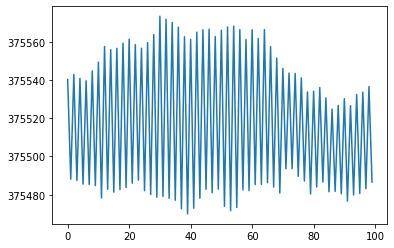

In [11]:
plt.plot(np.array(l_list)[:543498*100].reshape(543498, -1).sum(axis=0))

In [21]:
norm_g_list = [np.linalg.norm(i) for i in g_list]

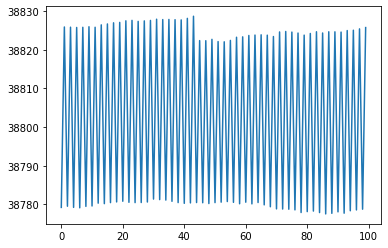

In [22]:
plt.plot(np.array(norm_g_list)[:543498*100].reshape(543498, -1).sum(axis=0))

In [30]:
np.linalg.norm(g_list[0])

0.11238866936307283

In [35]:
np.linalg.norm(g_list[-5])

0.08803943868131693

In [28]:
g_list[-3]

array([ 3.12074446e-02,  2.75784961e-02,  9.13611867e-04,  1.62006819e-02,
        3.53739729e-02, -2.71986666e-02, -3.98560072e-02, -5.88729720e-03,
        1.15584021e-02, -1.53209933e-03,  6.86104095e-03,  1.12362124e-03,
        2.61413336e-02,  2.50737767e-02,  1.25287726e-03,  1.76610292e-02,
        3.43410986e-03, -7.90527120e-03, -7.95252902e-03, -1.91782795e-02,
        1.63282699e-02, -6.63949070e-03,  4.23807029e-03, -1.73853034e-02,
        1.92390106e-02,  1.84190497e-02,  3.13886222e-02, -4.39638328e-07,
        2.36212029e-02,  3.05957259e-03,  4.17997914e-03,  1.62263892e-02,
        1.55888402e-02,  2.50522684e-02, -8.42567024e-03,  2.93723357e-03,
       -7.61433492e-03,  1.63340873e-02,  1.71850776e-02, -9.78127121e-03,
        6.69140840e-03, -7.84148530e-03,  4.60988154e-03,  1.21904686e-02])

In [ ]:
l_mul()

In [41]:
train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_mul'].values

In [43]:
l_mul(train_set_x, train_set_y, w)

(1828764,)

In [28]:
tx = train_set_x[:100]
ty = train_set_y[:100]
w = np.zeros(44*5)
z = np.array([np.dot(tx, w[i*44:(i+1)*44]) for i in range(5)])
zy = z[ty, np.arange(z.shape[1])]

In [34]:
np.log(np.exp(z).sum(axis=0)).shape

(100,)

In [9]:
tx.shape, ty.shape, z.shape

((100, 44), (100,), (5, 100))

In [11]:
data = np.random.rand(2,3)

In [24]:
import numpy as np

arr = np.array([[1,2,3], [4,5,6]])
y = [0, 1, 1]
result = arr[y,np.arange(arr.shape[1])]
print(result)


[1 5 6]


In [26]:
z.shape

(5, 100)

In [38]:
ty

array([3, 1, 4, ..., 3, 1, 4])

In [30]:
import numpy as np

z = [np.random.rand(44) for _ in range(5)]
z_arr = np.array(z)  # 转换为 numpy 数组，形状为 (5, 44)

y = np.random.randint(0, 5, size=100)  # 随机生成一个长度为 100，取值在 [0, 5) 之间的一维数组

result = np.take(z_arr.T, y, axis=0).T  # 沿着第二个维度进行索引，并将维度反转


In [34]:
z_arr.shape

(5, 44)

In [60]:
def Gradient_Descent_update(w, data_x, data_y, learning_rate, type='bin'):
    if type == 'bin':
        l = l_bin(data_x, data_y, w)
        g = l_bin_grad(data_x, data_y, w)

    elif type == 'multi':
        l = l_multi(data_x, data_y, w)
        g = l_multi_grad(data_x, data_y, w)
    else:
        raise ValueError('type must be bin or multi')
    w -= learning_rate * g
    if np.linalg.norm(w) > 1:
        w = w / np.linalg.norm(w)
    return w, g, l

def Gradient_Descent(df_feature, learning_rate, type='bin'):
    # T = data_x.shape
    # w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
    # return w, g, l
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    for data_x, data_y in zip(train_set_x, train_set_y):
        for _ in range(10):
            w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
            w_list.append(w)
            g_list.append(g)
            l_list.append(l)
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        for data_x, data_y in zip(train_set_x, train_set_y):
            for _ in range(10):
                w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
                w_list.append(w)
                g_list.append(g)
                l_list.append(l)
        
    
    return w_list, g_list, l_list, predict_list
    

In [61]:
wl, gl, ll, pl = Gradient_Descent(df_feature, 1e-3, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [54]:
# GD no iteration, 1e-3
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 315142 fn: 151948 tp: 257935 tn: 157562


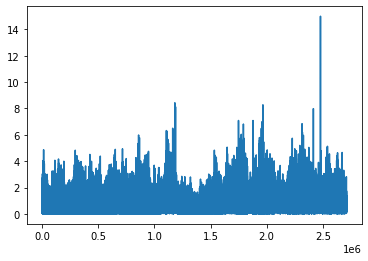

In [55]:
plt.plot(ll)

In [64]:
def Mini_Batch_Gradient_Descent_update(w, data_x, data_y, learning_rate, type='bin'):
    if type == 'bin':
        l = l_bin(data_x, data_y, w)
        g = l_bin_grad(data_x, data_y, w)

    elif type == 'multi':
        l = l_multi(data_x, data_y, w)
        g = l_multi_grad(data_x, data_y, w)
    else:
        raise ValueError('type must be bin or multi')
    # w -= learning_rate * g
    # if np.linalg.norm(w) > 1:
    #     w = w / np.linalg.norm(w)
    return w, g, l

def Mini_Batch_Gradient_Descent(df_feature, learning_rate, batch_size, type='bin'):
    # T = data_x.shape
    # w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
    # return w, g, l
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    B = 0
    for data_x, data_y in zip(train_set_x, train_set_y):
        w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
        w_list.append(w)
        g_list.append(g)
        l_list.append(l)
        B += 1
        if B == batch_size:
            w -= learning_rate * np.mean(g_list[-B:], axis=0)
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(w) * 10
            B = 0
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        B = 0
        for data_x, data_y in zip(train_set_x, train_set_y):
            w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
            w_list.append(w)
            g_list.append(g)
            l_list.append(l)
            B += 1
            if B == batch_size:
                w -= learning_rate * np.mean(g_list[-B:], axis=0)
                if np.linalg.norm(w) > 10:
                    w = w / np.linalg.norm(w) * 10
                B = 0
        
    
    return w_list, g_list, l_list, predict_list
    

In [67]:
wl, gl, ll, pl = Mini_Batch_Gradient_Descent(df_feature, 1e-2, 128, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [68]:
# MBGD no iteration, 1e-2, 64
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 326526 fn: 143094 tp: 266789 tn: 146178


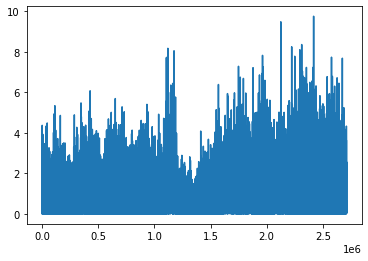

In [69]:
plt.plot(ll)

In [91]:
def Stochastic_Gradient_Descent_Momentum_update(w, data_x, data_y, learning_rate, type='bin'):
    if type == 'bin':
        l = l_bin(data_x, data_y, w)
        g = l_bin_grad(data_x, data_y, w)

    elif type == 'multi':
        l = l_multi(data_x, data_y, w)
        g = l_multi_grad(data_x, data_y, w)
    else:
        raise ValueError('type must be bin or multi')
    # w -= learning_rate * g
    # if np.linalg.norm(w) > 1:
    #     w = w / np.linalg.norm(w)
    return w, g, l

def Stochastic_Gradient_Descent_Momentum(df_feature, learning_rate, batch_size, beta, type='bin'):
    # T = data_x.shape
    # w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
    # return w, g, l
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    v = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    B = 0
    for data_x, data_y in zip(train_set_x, train_set_y):
        _w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
        w_list.append(_w)
        g_list.append(g)
        l_list.append(l)
        B += 1
        if B == batch_size:
            g = np.mean(g_list[-B:], axis=0)
            v = beta * v + (1 - beta) * g
            w = w - learning_rate * v
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(w) * 10
            B = 0
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        B = 0
        for data_x, data_y in zip(train_set_x, train_set_y):
            _w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
            w_list.append(_w)
            g_list.append(g)
            l_list.append(l)
            B += 1
            if B == batch_size:
                g = np.mean(g_list[-B:], axis=0)
                v = beta * v + (1 - beta) * g
                w = w - learning_rate * v
                if np.linalg.norm(w) > 10:
                    w = w / np.linalg.norm(w) * 10
                B = 0
        
    
    return w_list, g_list, l_list, predict_list
    

In [92]:
wl, gl, ll, pl = Stochastic_Gradient_Descent_Momentum(df_feature, 1e-2, 128, 0.5, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [93]:
# SGDM no iteration, 1e-2, 128. 0.5
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 334625 fn: 134413 tp: 275470 tn: 138079


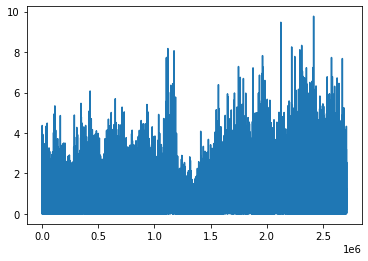

In [75]:
plt.plot(ll)

In [94]:
def NAG(df_feature, learning_rate, batch_size, beta, type='bin'):
    # T = data_x.shape
    # w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
    # return w, g, l
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    v = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    B = 0
    for data_x, data_y in zip(train_set_x, train_set_y):
        _w, g, l = Gradient_Descent_update(w-beta*v, data_x, data_y, learning_rate, type)
        w_list.append(_w)
        g_list.append(g)
        l_list.append(l)
        B += 1
        if B == batch_size:
            g = np.mean(g_list[-B:], axis=0)
            v = beta * v + learning_rate * g
            w = w -  v
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(w) * 10
            B = 0
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        B = 0
        for data_x, data_y in zip(train_set_x, train_set_y):
            _w, g, l = Gradient_Descent_update(w-beta*v, data_x, data_y, learning_rate, type)
            w_list.append(_w)
            g_list.append(g)
            l_list.append(l)
            B += 1
            if B == batch_size:
                g = np.mean(g_list[-B:], axis=0)
                v = beta * v + learning_rate * g
                w = w -  v
                if np.linalg.norm(w) > 10:
                    w = w / np.linalg.norm(w) * 10
                B = 0
        
    
    return w_list, g_list, l_list, predict_list
    

In [95]:
wl, gl, ll, pl = NAG(df_feature, 1e-2, 128, 0.5, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [96]:
# NAG no iteration, 1e-2, 128. 0.5
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 267810 fn: 191100 tp: 218783 tn: 204894


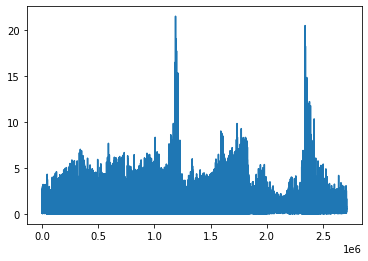

In [84]:
plt.plot(ll)

In [105]:
def AdaGrad(df_feature, learning_rate, batch_size, type='bin'):
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    r = 0
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    B = 0
    for data_x, data_y in zip(train_set_x, train_set_y):
        _w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
        w_list.append(_w)
        g_list.append(g)
        l_list.append(l)
        B += 1
        if B == batch_size:
            g = np.mean(g_list[-B:], axis=0)
            r += np.linalg.norm(g)**2
            w = w - g * learning_rate / np.sqrt(r)
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(w) * 10
            B = 0
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        B = 0
        for data_x, data_y in zip(train_set_x, train_set_y):
            _w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
            w_list.append(_w)
            g_list.append(g)
            l_list.append(l)
            B += 1
            if B == batch_size:
                g = np.mean(g_list[-B:], axis=0)
                r += np.linalg.norm(g)**2
                w = w -  g * learning_rate / np.sqrt(r)
                if np.linalg.norm(w) > 10:
                    w = w / np.linalg.norm(w) * 10
                B = 0
        
    
    return w_list, g_list, l_list, predict_list
    

In [106]:
wl, gl, ll, pl = AdaGrad(df_feature, 1e-2, 128, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [107]:
# AdaGrad no iteration, 1e-2, 128. 0.5
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 334593 fn: 134440 tp: 275443 tn: 138111


In [111]:
def Adam(df_feature, learning_rate, batch_size, beta1, beta2, type='bin'):
    w = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    m = np.zeros(44) if type == 'bin' else np.zeros((1, 44*5))
    v = 0
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    B = 0
    iter = 1
    for data_x, data_y in zip(train_set_x, train_set_y):
        _w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
        w_list.append(_w)
        g_list.append(g)
        l_list.append(l)
        B += 1
        if B == batch_size:
            g = np.mean(g_list[-B:], axis=0)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * np.linalg.norm(g)**2
            hatm = m / (1 - beta1**iter)
            hatv = v / (1 - beta2**iter)
            w = w - hatm * learning_rate / np.sqrt(hatv)
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(w) * 10
            B = 0
            iter += 1
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        B = 0
        for data_x, data_y in zip(train_set_x, train_set_y):
            _w, g, l = Gradient_Descent_update(w, data_x, data_y, learning_rate, type)
            w_list.append(_w)
            g_list.append(g)
            l_list.append(l)
            B += 1
            if B == batch_size:
                g = np.mean(g_list[-B:], axis=0)
                m = beta1 * m + (1 - beta1) * g
                v = beta2 * v + (1 - beta2) * np.linalg.norm(g)**2
                hatm = m / (1 - beta1**iter)
                hatv = v / (1 - beta2**iter)
                w = w - hatm * learning_rate / np.sqrt(hatv)
                if np.linalg.norm(w) > 10:
                    w = w / np.linalg.norm(w) * 10
                B = 0
                iter += 1
        
    
    return w_list, g_list, l_list, predict_list
    

In [112]:
wl, gl, ll, pl = Adam(df_feature, 1e-2, 128, 0.9, 0.999, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [113]:
# Adam no iteration, 1e-2, 128. 0.5
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 334774 fn: 134210 tp: 275673 tn: 137930


In [179]:
def ONS(df_feature, batch_size, gamma, epsilon, type='bin'):
    w = np.zeros(44) if type == 'bin' else np.zeros(44*5)
    A = epsilon * np.eye(44) if type == 'bin' else epsilon * np.eye(44*5)
    A_inverse = A / epsilon ** 2
    w_list = []
    g_list = []
    l_list = []
    predict_list = []
    train_set_x = df_feature.iloc[:dates_iloc[0], :].loc[:, alpha_list].values
    train_set_y = df_feature.iloc[:dates_iloc[0], :].loc[:, 'return_'+type].values
    B = 0
    for data_x, data_y in zip(train_set_x, train_set_y):
        _w, g, l = Gradient_Descent_update(w.reshape(-1,), data_x, data_y, 0, type)
        w_list.append(_w)
        g_list.append(g)
        l_list.append(l)
        B += 1
        if B == batch_size:
            g = np.mean(g_list[-B:], axis=0)
            A = A + np.matmul(g.reshape(-1, 1), g.reshape(1, -1))
            # A_inverse = A_inverse + np.matmul(A_inverse, np.matmul(g.reshape(-1, 1), np.matmul(g.reshape(1, -1), A_inverse))) / (1+np.matmul(g.reshape(1,-1), np.matmul(A_inverse, g.reshape(-1,1))))
            A_inverse = np.linalg.inv(A)
            
            w = (w.reshape(-1,1) - np.matmul(A_inverse, g.reshape(-1, 1)) / gamma).reshape(-1,)
            if np.linalg.norm(w) > 10:
                w = w / np.linalg.norm(w) * 10
            B = 0
    for month in range(15):
        print('begin month', month)
        test_set_x = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, alpha_list].values
        test_set_y = df_feature.iloc[dates_iloc[month]:dates_iloc[month+1], :].loc[:, 'return_'+type].values
        
        for data_x, data_y in zip(test_set_x, test_set_y):
            if type == 'bin':
                hat_z = np.dot(w, data_x)
                pred = 1 if hat_z > 0 else -1
            elif type == 'multi':
                hat_z = [np.dot(w[0, i*44:(i+1)*44], data_x) for i in range(5)]
                pred = np.argmax(hat_z)+1
            predict_list.append(pred)
        
        train_set_x = test_set_x
        train_set_y = test_set_y
        B = 0
        for data_x, data_y in zip(train_set_x, train_set_y):
            _w, g, l = Gradient_Descent_update(w, data_x, data_y, 0, type)
            w_list.append(_w)
            g_list.append(g)
            l_list.append(l)
            B += 1
            if B == batch_size:
                g = np.mean(g_list[-B:], axis=0)
                A = A + np.matmul(g.reshape(-1, 1), g.reshape(1, -1))
                # A_inverse = A_inverse + np.matmul(A_inverse, np.matmul(g.reshape(-1, 1), np.matmul(g.reshape(1, -1), A_inverse))) / (1+np.matmul(g.reshape(1,-1), np.matmul(A_inverse, g.reshape(-1,1))))
                A_inverse = np.linalg.inv(A)
                w = (w.reshape(-1,1) - np.matmul(A_inverse, g.reshape(-1, 1)) / gamma).reshape(-1,)
                if np.linalg.norm(w) > 10:
                    w = w / np.linalg.norm(w) * 10
                B = 0
        
    
    return w_list, g_list, l_list, predict_list

In [181]:
wl, gl, ll, pl = ONS(df_feature, 128, 100, 1, type='bin')

begin month 0
begin month 1
begin month 2
begin month 3
begin month 4
begin month 5
begin month 6
begin month 7
begin month 8
begin month 9
begin month 10
begin month 11
begin month 12
begin month 13
begin month 14


In [182]:
# Adam no iteration, 1e-2, 128. 0.5
fp, fn, tp, tn = 0, 0, 0, 0
for i in range(len(pl)):
    if pl[i] == 1 and bin_y[i] == 1:
        tp += 1
    elif pl[i] == 1 and bin_y[i] == -1:
        fp += 1
    elif pl[i] == -1 and bin_y[i] == 1:
        fn += 1
    elif pl[i] == -1 and bin_y[i] == -1:
        tn += 1
print('fp:',fp, 'fn:',fn, 'tp:',tp, 'tn:',tn)

fp: 137360 fn: 290873 tp: 119010 tn: 335344


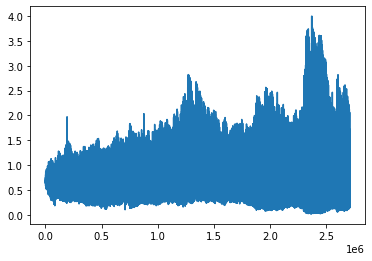

In [183]:
plt.plot(ll)

In [ ]:
import numpy as np
import pandas as pd
import numba as nb

    
def AdaGrad(data_x, data_y, learning_rate, batch_size, momentum_factor, type='bin'):
    if type=='bin':
        w = np.zeros((1, data_x.shape[1]))
        ws = [w]
        gs = []
        ls = []
        for i in range(data_x.shape[0] // batch_size):
            r = 0 
            w = ws[-1]
            ls.append(l_bin(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w))
            g = l_bin_grad(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w)
            r = r + np.linalg.norm(g) ** 2
            w = w - learning_rate / (np.sqrt(r) + 1e-8) * g
            w = w / np.linalg.norm(w)
            ws.append(w)
            gs.append(g)
        return ws, gs, ls
    elif type=='multi':
        w = np.zeros((1, data_x.shape[1]))
        ws = [w]
        gs = []
        ls = []
        for i in range(data_x.shape[0] // batch_size):
            r = 0 
            w = ws[-1]
            ls.append(l_multi(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w))
            g = l_multi_grad(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w)
            r = r + np.linalg.norm(g) ** 2
            w = w - learning_rate / (np.sqrt(r) + 1e-8) * g
            w = w / np.linalg.norm(w)
            ws.append(w)
            gs.append(g)
        return ws, gs, ls
    
def Adam(data_x, data_y, learning_rate, batch_size, beta1, beta2, type='bin'):
    if type == 'bin':
        w = np.zeros((1, data_x.shape[1]))
        ws = [w]
        gs = []
        ls = []
        m = np.zeros((1, data_x.shape[1]))
        v = 0
        for i in range(data_x.shape[0] // batch_size):
            w = ws[-1]
            ls.append(l_bin(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w))
            g = l_bin_grad(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * np.linalg.norm(g) ** 2
            w = w - learning_rate / (np.sqrt(v / 1-beta2 ** i) + 1e-8) * m / (1-beta1 ** i)
            w = w / np.linalg.norm(w)
            ws.append(w)
            gs.append(g)
        return ws, gs, ls
    elif type == 'multi':
        w = np.zeros((1, data_x.shape[1]))
        ws = [w]
        gs = []
        ls = []
        m = np.zeros((1, data_x.shape[1]))
        v = 0
        for i in range(data_x.shape[0] // batch_size):
            w = ws[-1]
            ls.append(l_multi(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w))
            g = l_multi_grad(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * np.linalg.norm(g) ** 2
            w = w - learning_rate / (np.sqrt(v / 1-beta2 ** i) + 1e-8) * m / (1-beta1 ** i)
            w = w / np.linalg.norm(w)
            ws.append(w)
            gs.append(g)
        return ws, gs, ls
    
def Newton_Method(data_x, data_y, gamma, epsilon, batch_size, type='bin'):
    if type == 'bin':
        w = np.zeros((1, data_x.shape[1]))
        ws = [w]
        gs = []
        ls = []
        H = epsilon * np.eye(data_x.shape[1])
        for i in range(data_x.shape[0] // batch_size):
            w = ws[-1]
            ls.append(l_bin(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w))
            g = l_bin_grad(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w)
            H = H + np.outer(g, g)
            w = w - 1 / gamma * np.linalg.inv(H) @ g
            w = w / np.linalg.norm(w)
            ws.append(w)
            gs.append(g)
        return ws, gs, ls
    elif type == 'multi':
        w = np.zeros((1, data_x.shape[1]))
        ws = [w]
        gs = []
        ls = []
        H = epsilon * np.eye(data_x.shape[1])
        for i in range(data_x.shape[0] // batch_size):
            w = ws[-1]
            ls.append(l_multi(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w))
            g = l_multi_grad(data_x[i*batch_size:(i+1)*batch_size, :], data_y[i*batch_size:(i+1)*batch_size], w)
            H = H + np.outer(g, g)
            w = w - 1 / gamma * np.linalg.inv(H) @ g
            w = w / np.linalg.norm(w)
            ws.append(w)
            gs.append(g)
        return ws, gs, 

In [ ]:
fields = list(data.keys())

In [ ]:
open_ = data['OpenPrice']
res = open_.count(axis=1)
tickers = list(res[res > 900].index)

In [ ]:
dates = [i for i in list(open_.columns) if i <= '20210329']

In [ ]:
df_selected = df_feature[['date', 'ticker', 'high', 'open_', 'low', 'close_', 'volume', 'vwap', 'value', 'ret'] + ['alpha'+str(i) for i in selected_alpha]]

In [ ]:
len(selected_alpha)

In [ ]:
save = df_selected.dropna().reset_index(drop=True)

In [ ]:
save['return_bin'] = np.sign(save['ret'] - 0.0013)

In [ ]:
save['return_mul'] = (save['ret']).apply(lambda x: 1 if x<-0.02 else 2 if x<-0.005 else 3 if x<0.005 else 4 if x<0.015 else 5)

In [ ]:
save.to_pickle('/Volumes/WDSN570/df_feature_clean_v2.pkl')

In [ ]:
open_.iloc[:20,:20]

In [ ]:
for num in selected_alpha:
    name = 'alpha'+str(num)
    _m = save[name].mean()
    _s = save[name].std()
    save[name] = save[name].apply(lambda x: _m+5*_s if x>_m+5*_s else _m-5*_s if x<_m-5*_s else x)

In [ ]:
tmp_df = open_.iloc[:20,:20].copy()

In [ ]:
tmp_df

In [ ]:
tmp_df.iloc[0,0]=0

In [ ]:
tmp_df['000001'] = tmp_df['000001'].apply(lambda x: _m+5*_s if x>_m+5*_s else _m-5*_s if x<_m-5*_s else x)

In [ ]:
tmp_df

In [ ]:
save['alpha1'].std(),save['alpha1'].mean()

In [ ]:
for i in selected_alpha:
    name='alpha'+str(i)
    print(name,end=' ')
    print(save[save[name]<-5*save[name].std() +save[name].mean()].shape, end=' ')
    print(save[save[name]>5*save[name].std() + save[name].mean()].shape)

In [ ]:
for i in range(100):
    print(i, np.percentile(save['ret'].values-0.0013, i))

In [ ]:
df_feature = pd.read_pickle('/Volumes/WDSN570/data_df_save1.pkl')
for i in range(2,7):
    tmp_df = pd.read_pickle('/Volumes/WDSN570/data_df_save'+str(i)+'.pkl')
    df_feature = pd.merge(df_feature, tmp_df, how='left', on=['date','ticker'])

In [ ]:
dates = list(df_feature[['date']].drop_duplicates()['date'].values)

In [ ]:
df_feature = df_feature[df_feature['date']<='20210329']

In [ ]:
df_feature.count()

In [ ]:
original_alpha = [1,2,3,4,5,6,7,8,9,12, 14,15,16,17,18,19,20,25,27,28,29,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,72]

In [ ]:
selected_alpha = [1,2,3,4,5,6,7,8,9,12,
                  14,15,16,17,18,19,20,27,28,29,
                  32,33,35,36,38,39,40,43,44,45,
                  46,47,48,52,53,54,60,61,62,63,
                  64,65,67,68]

In [ ]:
res = df_feature.count().to_dict()

In [ ]:
for k in res.keys():
    if res[k]<30000000: 
        #if int(k[-2:]) in selected_alpha:
            print(k, res[k])

In [ ]:
df_feature['return_bin'] = np.sign(df_feature['ret']-0.0013)

In [ ]:
df_feature['date'].count()

In [ ]:
df_feature['return_bin'].mean()

In [ ]:
plt.hist(df_feature['ret'].values,bins=100)

In [ ]:
np.percentile(df_feature['ret'].values,100)

In [ ]:
max(df_feature['ret'].values)

In [ ]:
df_feature[df_feature['ret']>0.5]

In [ ]:
open_ = data['OpenPrice']

In [ ]:
open_.loc['300937',:].iloc[990:]

In [ ]:
open_.loc['300869',:].count()

In [ ]:
df_feature[(df_feature['ticker']=='300937') & (df_feature['date']>'20210125')]

In [ ]:
data["HighestPrice"].loc[tickers].iloc[:,:1032].T

In [ ]:
high = data["HighestPrice"].loc[tickers].iloc[:,:1032].T
floatshare = data["FloatShare"].loc[tickers].iloc[:,:1032].T
open_ = data["OpenPrice"].loc[tickers].iloc[:,:1032].T
low = data["LowestPrice"].loc[tickers].iloc[:,:1032].T
close_ = data["ClosePrice"].loc[tickers].iloc[:,:1032].T
volume = data["TradeVolume"].loc[tickers].iloc[:,:1032].T
vwap = data["VWAP"].loc[tickers].iloc[:,:1032].T

value = data["TradeValue"].loc[tickers].iloc[:,:1032].T

# market_cap = data["FloatMarketValue"].T
# turnover = data["TurnOverRate"].T / 100

ret = open_.pct_change().shift(-2)

In [ ]:
high.count().sum()

In [ ]:
def calc_alpha1(high, low):
    """

    :param high:
    :param low:
    :return:
    """

    result = ((high - low) / (high + low)).rolling(20, min_periods=10).std()

    return -result


alpha1 = calc_alpha1(high, low)

In [ ]:
def calc_alpha2(close, vwap):
    result = (close / vwap - 1).ewm(halflife=20).mean()
    return -result
alpha2 = calc_alpha2(close_, vwap)

In [ ]:
def calc_alpha3(low, high, close, open):
    tmp = (high / low) - np.maximum(close, open) / np.minimum(close, open)
    alpha = -tmp.ewm(halflife=20).std()
    return alpha
alpha3 = calc_alpha3(low, high, close_, open_)

In [ ]:
def cs_regression(y, x):
    result = np.full_like(x, fill_value=np.nan)

    for i in prange(x.shape[0]):
        x1, y1 = x[i, :], y[i, :]
        valid = np.bitwise_and(np.isfinite(x1), np.isfinite(y1))
        x1, y1 = x1[valid], y1[valid]

        if len(x1) > 100 and len(y1) > 100:
            tmp = np.column_stack((np.ones(len(x1)), x1))
            cov = tmp.T.dot(tmp)
            if np.linalg.det(cov) == 0:
                continue
            coef = np.linalg.inv(cov).dot(tmp.T).dot(y1)
            pred = tmp.dot(coef)
            resid = y1 - pred
            result[i][valid] = resid

    return result

def cs_regression_multiple(y, *args):
    """
    only work for two variable case
    :param y:
    :param window:
    :param args:
    :return:
    """
    result = np.full_like(y, fill_value=np.nan)

    for i in range(y.shape[0]):
        x1, y1 = np.array([arg[i, :] for arg in args]).T, y[i, :]

        valid = np.bitwise_and(np.isfinite(x1[:, 0]), np.isfinite(y1))

        for j in range(1, len(args)):
            valid = np.bitwise_and(valid, np.isfinite(x1[:, j]))

        x1, y1 = x1[valid], y1[valid]

        if len(x1) > 50 and len(y1) > 50:
            tmp = np.column_stack((np.ones(len(x1)), x1))
            cov = tmp.T.dot(tmp)
            if np.linalg.det(cov) == 0:
                continue
            coef = np.linalg.inv(cov).dot(tmp.T).dot(y1)
            pred = tmp.dot(coef)
            resid = y1 - pred
            result[i][valid] = resid

    return result

def calc_alpha4(vwap, open, close):
    vwap_ret = vwap.pct_change()
    open_close_ret = open / close.shift(1) - 1
    ret = close.pct_change()

    resid = cs_regression_multiple(vwap_ret.values, open_close_ret.values, ret.values)

    alpha = -pd.DataFrame(resid, index=vwap.index, columns=vwap.columns).rolling(20, min_periods=10).std()
    return alpha
alpha4 = calc_alpha4(vwap, open_, close_)

In [ ]:
def calc_alpha5(volume, vwap):
    log_volume = np.log(volume)
    ret = vwap.pct_change()
    p = ret * log_volume.pct_change()
    alpha = p.ewm(halflife=10).mean()

    return alpha
alpha5 = calc_alpha5(volume, vwap)

In [ ]:
@njit
def ts_corr(input1, input2, period=20):
    """
    Numpuy version corr
    Params:
        input1:
        input2:
    """

    result = np.full_like(input1, fill_value=np.nan)
    for i in prange(input1.shape[1]):
        for j in range(period, input1.shape[0]):
            tmp1, tmp2 = input1[j - period:j, i], input2[j - period:j, i]
            valid = np.bitwise_and(np.isfinite(tmp1), np.isfinite(tmp2))
            corr = np.corrcoef(tmp1[valid], tmp2[valid])[0][1]
            result[j, i] = corr
    return result

def calc_alpha6(volume, close):
    result = -1 * ts_corr(volume.values, close.values, 20)
    alpha = pd.DataFrame(result, index=volume.index, columns=volume.columns)

    # 新加的特性，认为这个是异常值
    alpha[abs(alpha) > 0.95] = np.nan

    return alpha

alpha6 = calc_alpha6(volume, close_)

In [ ]:
def calc_alpha7(volume, open, close):
    result = -1 * ts_corr(volume.pct_change().values, (open / close.shift(1) - 1).values, 20)
    alpha = pd.DataFrame(result, index=volume.index, columns=volume.columns)

    # 新加的特性，认为这个是异常值
    alpha[abs(alpha) > 0.95] = np.nan

    return alpha

alpha7 = calc_alpha7(volume, open_, close_)

In [ ]:
def calc_alpha8(volume, close):
    result = -1 * ts_corr(volume.pct_change().values, close.pct_change().values, 20)
    alpha = pd.DataFrame(result, index=volume.index, columns=volume.columns)

    # 新加的特性，认为这个是异常值
    alpha[abs(alpha) > 0.95] = np.nan

    return alpha
alpha8 = calc_alpha8(volume, close_)

In [ ]:
def calc_alpha9(vwap, volume, window=20):
    @njit
    def _ts_corr(input1, input2, period):
        """
        Numpuy version corr
        Params:
            input1: price
            input2: volume
        """

        result2 = np.full_like(input1, fill_value=np.nan)
        for i in prange(input1.shape[1]):
            for j in range(period, input1.shape[0]):
                tmp1, tmp2 = input1[j - period:j, i], input2[j - period:j, i]
                valid = np.bitwise_and(np.isfinite(tmp1), np.isfinite(tmp2))

                tmp1, tmp2 = tmp1[valid], tmp2[valid]

                down1, down2 = tmp1[tmp1 < 0], tmp2[tmp1 < 0]

                corr2 = np.corrcoef(down1, down2)[0][1]
                result2[j, i] = corr2

        return result2

    ret = vwap.pct_change()
    ret = ret.replace(np.inf, np.nan)
    ret = ret.replace(-np.inf, np.nan)

    volume_pct_chg = volume.pct_change()
    volume_pct_chg = volume_pct_chg.replace(np.inf, np.nan)
    volume_pct_chg = volume_pct_chg.replace(-np.inf, np.nan)

    corr2 = _ts_corr(ret.values, volume_pct_chg.values, window)
    corr2 = pd.DataFrame(corr2, index=vwap.index, columns=vwap.columns)

    return corr2
alpha9 = calc_alpha9(vwap, volume)

In [ ]:
def calc_alpha12(close_, high, low, hl=20):
    """比传统的振幅好一些"""

    ret = close_.pct_change()

    mask1 = (volume > volume.rolling(5).mean()).astype(int)
    mask4 = (close_ > close_.rolling(5).mean()).astype(int)
    mask5 = (ret > 0).astype(int)

    ratio1 = high / low  # 似乎不需要复权
    ratio1 = ratio1 * mask1
    alpha1_ewm = ratio1.replace(0, np.nan)
    alpha1_ewm = alpha1_ewm.ewm(halflife=hl, ignore_na=True).std()

    ratio4 = (high / low) * mask4
    ratio5 = (high / low) * mask5

    alpha4_ewm = ratio4.replace(0, np.nan).ewm(halflife=hl, ignore_na=True).std()
    alpha5_ewm = ratio5.replace(0, np.nan).ewm(halflife=hl, ignore_na=True).std()

    return alpha4_ewm + alpha5_ewm
alpha12 = calc_alpha12(close_, high, low)

In [ ]:
def calc_alpha14(close_, volume):
    """布林带上下轨的交易量的比值"""
    location3 = (close_ >= (
            close_.rolling(20, min_periods=10).mean() + close_.rolling(20, min_periods=10).std())).astype(int)
    location4 = (close_ <= (
            close_.rolling(20, min_periods=10).mean() - close_.rolling(20, min_periods=10).std())).astype(int)
    volume_up = (volume * location3).replace(0, np.nan)
    volume_down = (volume * location4).replace(0, np.nan)

    volume_ratio = np.log(volume_up.ewm(halflife=30).mean() / volume_down.ewm(halflife=30).mean())

    return volume_ratio
alpha14 = calc_alpha14(close_, volume)

In [ ]:
def ts_regression_residual_vol(y, x, period=20):
    result = np.full_like(y, fill_value=np.nan)

    for i in range(y.shape[0] - period):
        for j in range(y.shape[1]):
            y1 = y[i:i + period, j]
            xs = x[i:i + period, j]

            valid = np.bitwise_and(np.isfinite(xs), np.isfinite(y1))

            y1 = y1[valid]
            x1 = xs[valid]

            if len(x1) >= 3 and len(y1) >= 3:  # otherwise too few data
                tmp = np.column_stack((np.ones(len(x1)), x1))
                cov = tmp.T.dot(tmp)
                if np.linalg.det(cov) == 0:
                    continue
                coef = np.linalg.inv(cov).dot(tmp.T).dot(y1)
                pred = tmp.dot(coef)
                resid = y1 - pred
                result[i + period, j] = np.std(resid)

    return result
def calc_alpha15(volume):
    ar = ts_regression_residual_vol(volume.values, volume.shift(1).values, 20)
    factor = pd.DataFrame(ar, index=volume.index, columns=volume.columns)
    return factor
alpha15 = calc_alpha15(volume)

In [ ]:
def calc_alpha16(volume, close_, window=30):
    def calc(variable, mask, hl=30, inverse=False, method="mean"):
        if inverse:
            tmp = variable * ((mask - 1) * -1)
        else:
            tmp = variable * mask

        tmp = tmp.replace(0, np.nan)

        if method == "mean":
            result = tmp.ewm(halflife=hl, ignore_na=True).mean()
        elif method == "std":
            result = tmp.ewm(halflife=hl, ignore_na=True).std()

        return result

    variable3 = vwap / close_

    mask1 = (volume > volume.rolling(5).mean()).astype(int)

    factor6 = calc(variable3, mask1, inverse=False, method="mean")
    raw2 = variable3.ewm(halflife=window).mean()

    return factor6 + raw2
alpha16 = calc_alpha16(volume, close_, window=30)

In [ ]:
def calc_alpha17(volume, close_, window=20):
    def calc(variable, mask, hl=30, inverse=False, method="mean"):
        if inverse:
            tmp = variable * ((mask - 1) * -1)
        else:
            tmp = variable * mask

        tmp = tmp.replace(0, np.nan)

        if method == "mean":
            result = tmp.ewm(halflife=hl, ignore_na=True).mean()
        elif method == "std":
            result = tmp.ewm(halflife=hl, ignore_na=True).std()

        return result

    variable3 = vwap / close_

    mask2 = (volume > volume.rolling(20, min_periods=5).mean()).astype(int)

    factor17 = calc(variable3, mask2, hl=window, inverse=False, method="mean")

    return factor17
alpha17 = calc_alpha17(volume, close_)

In [ ]:
def calc_alpha18(high, low, close_, window=30):
    def calc(variable, mask, hl=30, inverse=False, method="mean"):
        if inverse:
            tmp = variable * ((mask - 1) * -1)
        else:
            tmp = variable * mask

        tmp = tmp.replace(0, np.nan)

        if method == "mean":
            result = tmp.ewm(halflife=hl, ignore_na=True).mean()
        elif method == "std":
            result = tmp.ewm(halflife=hl, ignore_na=True).std()

        return result

    variable1 = high / low
    mask3 = (close_.ewm(halflife=5).mean() > close_.ewm(halflife=20).mean()).astype(int)
    factor27 = calc(variable1, mask3, hl=window, inverse=False, method="std")
    return factor27
alpha18 = calc_alpha18(high, low, close_, window=30)

In [ ]:
def calc_alpha19(volume, close_, window=30):
    ret = close_.pct_change()
    variable2 = close_ / open_
    variable3 = vwap / close_

    raw2 = variable2.ewm(halflife=window).mean()
    raw3 = variable3.ewm(halflife=window).mean()

    return (raw2.fillna(0) + raw3.fillna(0)).replace(0, np.nan)
alpha19 = calc_alpha19(volume, close_)

In [ ]:
def calc_alpha20(volume, close_, window=20):
    def calc(variable, mask, hl=30, inverse=False, method="mean"):
        if inverse:
            tmp = variable * ((mask - 1) * -1)
        else:
            tmp = variable * mask

        tmp = tmp.replace(0, np.nan)

        if method == "mean":
            result = tmp.ewm(halflife=hl, ignore_na=True).mean()
        elif method == "std":
            result = tmp.ewm(halflife=hl, ignore_na=True).std()

        return result

    ret = close_.pct_change()
    variable3 = vwap / close_

    mask4 = (close_ > close_.rolling(5).mean()).astype(int)
    mask5 = (ret > 0).astype(int)

    factor39 = calc(variable3, mask4, hl=window, inverse=False, method="mean")
    factor47 = calc(variable3, mask5, hl=window, inverse=False, method="mean")

    return factor39 + factor47
alpha20 = calc_alpha20(volume, close_)

In [ ]:
def calc_alpha25(high, low):
    """
    highled correlated with alpha3 or alpha1 or alpha16
    :param high:
    :param low:
    :return:
    """
    high_ret = high.pct_change()
    low_ret = low.pct_change()

    high_vol = high_ret.ewm(halflife=10).std()
    low_vol = low_ret.ewm(halflife=10).std()

    result = (high_vol / low_vol)
    result = result.ewm(halflife=5).mean()
    result[result.ge(result.quantile(0.9, axis=1), axis=0)] = np.nan

    # result = result.clip(result.quantile(0.1, axis=1), result.quantile(0.9, axis=1), axis=0)

    return result
alpha25 = calc_alpha25(high, low)

In [ ]:
def calc_alpha27(high, low, open_):
    """
    ADTM

    """
    dtm = np.maximum(high / open_ - 1, open_.pct_change())
    dbm = np.maximum(open_ / low - 1, open_.pct_change())
    # stm = dtm.rolling(20, min_periods=10).sum()
    # sbm = dbm.rolling(20, min_periods=10).sum()
    stm = dtm.ewm(halflife=10).mean()
    sbm = dbm.ewm(halflife=10).mean()

    adtm = (sbm - stm) / (stm + sbm)

    return adtm.ewm(halflife=5).mean()
alpha27 = calc_alpha27(high, low, open_)

In [ ]:
def calc_alpha28(vwap):
    twap60 = vwap.rolling(60, min_periods=20).mean()
    vwap60 = (vwap * volume).rolling(60, min_periods=20).sum() / volume.rolling(60, min_periods=20).sum()
    ratio = np.log(twap60 / vwap60)

    return ratio
alpha28 = calc_alpha28(vwap)

In [ ]:
def calc_alpha29(high, low, ):
    high_ma = high.ewm(halflife=5).mean()
    low_ma = low.ewm(halflife=5).mean()

    result = (high_ma / low_ma).rolling(20, min_periods=10).std()

    return result
alpha29 = calc_alpha29(high, low)

In [ ]:
def calc_alpha32(close_, volume, short_window=20, long_window=60):
    ma20 = close_.rolling(short_window, min_periods=short_window // 2).mean()
    mask_above_ma20 = (close_ > ma20).astype(int).replace(0, np.nan)

    vol_mask_above_ma20_mean = (volume * mask_above_ma20).rolling(long_window, min_periods=10).mean()
    close_distance_mask_to_ma20 = close_ / (close_ * mask_above_ma20).rolling(long_window, min_periods=10).mean()

    vol_mask_above_ma20_ratio = volume / vol_mask_above_ma20_mean

    deviation1 = ts_corr(vol_mask_above_ma20_ratio.values, close_distance_mask_to_ma20.values, 30)
    deviation1 = pd.DataFrame(deviation1, index=close_.index, columns=close_.columns)

    deviation1[abs(deviation1) > 0.9] = np.nan

    deviation1_ewm = deviation1.ewm(halflife=10).mean()

    return deviation1_ewm
alpha32 = calc_alpha32(close_, volume)

In [ ]:
def calc_alpha33(close_, volume, short_window=20, long_window=60):
    """
    Most correlated alpha eod_jxma_alpha019: 0.6564167243317636
    :param close_:
    :param volume:
    :param short_window:
    :param long_window:
    :return:
    """
    ma20 = close_.rolling(short_window, min_periods=short_window // 2).mean()
    mask_above_ma20 = (close_ > ma20).astype(int).replace(0, np.nan)

    range_rate_per_log_volume = np.exp((high / low)) / np.sqrt(volume)
    range_rate_per_log_volume_mask_above_20 = (range_rate_per_log_volume * mask_above_ma20).replace(0, np.nan)
    range_rate_per_log_volume_mask_above_20_mean = \
        range_rate_per_log_volume_mask_above_20.rolling(long_window, min_periods=long_window // 10).mean()

    return range_rate_per_log_volume_mask_above_20_mean
alpha33 = calc_alpha33(close_, volume)

In [ ]:
class Cut:
    variable1 = vwap / close_
    variable2 = vwap / open_
    variable3 = vwap / high
    variable4 = vwap / low
    variable5 = close_ / open_
    variable6 = open_ / close_.shift(1)
    variable7 = high / np.maximum(close_, open_)
    variable8 = np.minimum(open_, close_) / low

#     variable9 = close_.pct_change() * universe
#     variable10 = variable9.rolling(5).std()
#     variable11 = turnover
    variable12 = high / low
    variable13 = np.log(value)
    variable14 = np.log(volume)

    # 12.1 新加变量
    variable15 = (high - low) / (high + low)
    variable16 = (high + low).pct_change()
    variable17 = (open_ + close_).pct_change()
    variable18 = abs((open_ - close_)) / (high - low)
    variable19 = (high / low) / np.log(volume)
    variable20 = abs(close_ / open_) / np.log(volume)
    variable21 = vwap / (close_ + open_)
    variable22 = vwap / (high + low)

    mask1 = (close_ >= close_.rolling(5).max()).astype(int)
    mask2 = (close_ >= close_.rolling(20, min_periods=10).max()).astype(int)
    mask3 = (close_ <= close_.rolling(60, min_periods=30).max()).astype(int)

    mask4 = (close_ <= close_.rolling(5).min()).astype(int)
    mask5 = (close_ <= close_.rolling(20, min_periods=10).min()).astype(int)
    mask6 = (close_ <= close_.rolling(60, min_periods=30).min()).astype(int)

    mask7 = (close_ <= close_.rolling(5).mean() - close_.rolling(5).std()).astype(int)
    mask8 = (close_ <= close_.rolling(20, min_periods=10).mean() - close_.rolling(20, min_periods=10).std()).astype(int)
    mask9 = (close_ >= close_.rolling(5).mean() + close_.rolling(5).std()).astype(int)
    mask10 = (close_ >= close_.rolling(20, min_periods=10).mean() + close_.rolling(20, min_periods=10).std()).astype(
        int)

    mask11 = (close_.ewm(halflife=5).mean() >= close_.ewm(halflife=20).mean()).astype(int)

    mask12 = (volume >= volume.rolling(5).mean()).astype(int)
    mask13 = (volume >= volume.rolling(20, min_periods=10).mean()).astype(int)
    mask14 = (vwap - np.minimum(close_, open_)) > (np.maximum(close_, open_) - vwap)

    @staticmethod
    def _helper(variable, mask, window):
        up_df = (variable * mask).replace(0, np.nan)
        up_mean = up_df.rolling(window, min_periods=window // 10).mean()
        up_std = up_df.rolling(window, min_periods=window // 10).std()
        up_log_zscore = signlog(up_mean / up_std).replace(np.inf, np.nan).replace(-np.inf, np.nan)

        down_df = (variable * (mask + 1)).replace(2, np.nan)  # opposite way
        down_mean = down_df.rolling(window, min_periods=window // 10).mean()
        down_std = down_df.rolling(window, min_periods=window // 10).std()
        down_log_zscore = signlog(down_mean / down_std).replace(np.inf, np.nan).replace(-np.inf, np.nan)

        mean_ratio = (up_mean / down_mean).replace(np.inf, np.nan).replace(-np.inf, np.nan)
        std_ratio = (up_std / down_std).replace(np.inf, np.nan).replace(-np.inf, np.nan)
        zscore_ratio = (up_log_zscore / down_log_zscore).replace(np.inf, np.nan).replace(-np.inf, np.nan)

        return up_mean, up_std, up_log_zscore, mean_ratio, std_ratio, zscore_ratio

    @classmethod
    def calc_alpha34(self):
        mean2, _, _, _, _, _ = self._helper(self.variable1, self.mask2, window=60)

        return mean2

    @classmethod
    def calc_alpha35(self):
        _, _, _, _, ud_std_ratio2, _ = self._helper(self.variable3, self.mask9, window=60)

        return ud_std_ratio2

    @classmethod
    def calc_alpha36(self):
        _, std1, _, _, _, _ = self._helper(self.variable14, self.mask3, window=60)

        return std1

    @classmethod
    def calc_alpha37(self):
        mean2, _, _, _, _, _ = self._helper(self.variable14, self.mask2, window=60)

        return mean2

    @classmethod
    def calc_alpha38(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable14, self.mask3, window=60)

        return log_zscore

    @classmethod
    def calc_alpha39(self):
        _, _, _, mean_ratio2, _, _ = self._helper(self.variable15, self.mask1, window=60)

        return mean_ratio2

    @classmethod
    def calc_alpha40(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable15, self.mask3, window=60)

        return log_zscore

    @classmethod
    def calc_alpha41(self):
        _, _, _, mean_ratio1, _, _ = self._helper(self.variable15, self.mask8, window=60)

        return mean_ratio1

    @classmethod
    def calc_alpha42(self):
        _, _, _, mean_ratio1, _, _ = self._helper(self.variable15, self.mask10, window=60)

        return mean_ratio1

    @classmethod
    def calc_alpha43(self):
        _, _, _, _, _, ud_zscore2 = self._helper(self.variable15, self.mask1, window=60)

        return ud_zscore2

    @classmethod
    def calc_alpha44(self):
        mean, _, _, _, _, _ = self._helper(self.variable1, self.mask3, window=60)

        return mean

    @classmethod
    def calc_alpha45(self):
        mean3, _, _, _, _, _ = self._helper(self.variable5, self.mask12, window=60)

        return mean3

    @classmethod
    def calc_alpha46(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable19, self.mask13, window=60)

        return log_zscore

    @classmethod
    def calc_alpha47(self):
        _, _, _, _, _, ud_log_zscore = self._helper(self.variable20, self.mask1, window=60)

        return ud_log_zscore

    @classmethod
    def calc_alpha48(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable20, self.mask3, window=60)

        return log_zscore

    @classmethod
    def calc_alpha49(self):
        _, _, _, _, _, ud_log_zscore = self._helper(self.variable20, self.mask10, window=60)

        return ud_log_zscore

    @classmethod
    def calc_alpha50(self):
        _, _, _, _, _, ud_log_zscore = self._helper(self.variable3, self.mask2, window=60)

        return ud_log_zscore

    @classmethod
    def calc_alpha51(self):
        mean, _, _, _, _, _ = self._helper(self.variable1, self.mask10, window=60)

        return mean

    @classmethod
    def calc_alpha52(self):
        mean2, _, _, _, _, _ = self._helper(self.variable1, self.mask12, window=60)

        return mean2

    @classmethod
    def calc_alpha53(self):
        _, _, _, _, _, log_zscore = self._helper(self.variable3, self.mask9, window=120)
        return log_zscore

    @classmethod
    def calc_alpha54(self):
        mean1, _, _, _, _, _ = self._helper(self.variable5, self.mask3, window=120)
        return mean1

    @classmethod
    def calc_alpha55(self):
        _, _, _, _, std_ratio, _ = self._helper(self.variable9, self.mask1, window=120)
        return std_ratio

    @classmethod
    def calc_alpha56(self):
        _, _, _, mean_ratio, _, _ = self._helper(self.variable10, self.mask10, window=120)
        return mean_ratio

    @classmethod
    def calc_alpha57(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable11, self.mask3, window=60)
        return log_zscore

    @classmethod
    def calc_alpha58(self):
        _, _, _, mean_ratio, _, _ = self._helper(self.variable11, self.mask4, window=60)
        return mean_ratio

    @classmethod
    def calc_alpha59(self):
        _, _, _, _, std_ratio, _ = self._helper(self.variable11, self.mask8, window=120)
        return std_ratio

    @classmethod
    def calc_alpha60(self):
        _, std, _, _, _, _ = self._helper(self.variable14, self.mask13, window=120)

        return std

    @classmethod
    def calc_alpha61(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable14, self.mask12, window=120)

        return log_zscore

    @classmethod
    def calc_alpha62(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable14, self.mask3, window=120)

        return log_zscore

    @classmethod
    def calc_alpha63(self):
        _, std, _, _, _, _ = self._helper(self.variable14, self.mask4, window=120)

        return std

    @classmethod
    def calc_alpha64(self):
        _, _, _, mean_ratio2, _, _ = self._helper(self.variable15, self.mask1, window=120)

        return mean_ratio2

    @classmethod
    def calc_alpha65(self):
        _, _, _, mean_ratio2, _, _ = self._helper(self.variable15, self.mask7, window=120)

        return mean_ratio2

    @classmethod
    def calc_alpha66(self):
        _, _, _, mean_ratio1, _, _ = self._helper(self.variable15, self.mask8, window=120)

        return mean_ratio1

    @classmethod
    def calc_alpha67(self):
        _, _, _, _, std_ratio2, _ = self._helper(self.variable17, self.mask9, window=120)

        return std_ratio2

    @classmethod
    def calc_alpha68(self):
        _, _, _, _, _, ud_zscore = self._helper(self.variable19, self.mask13, window=120)

        return ud_zscore

    @classmethod
    def calc_alpha69(self):
        _, _, log_zscore, _, _, _ = self._helper(self.variable11, self.mask13, window=60)

        return log_zscore

    @classmethod
    def calc_alpha70(self):
        _, _, _, mean_ratio1, _, _ = self._helper(self.variable11, self.mask7, window=60)

        return mean_ratio1


In [ ]:
def signlog(x):
    return np.sign(x) * np.log(np.abs(x) + 1e-5)
c = Cut()
alpha34 = c.calc_alpha34()
alpha35 = c.calc_alpha35()
alpha36 = c.calc_alpha36()
alpha37 = c.calc_alpha37()


In [ ]:
alpha38 = c.calc_alpha38()
alpha39 = c.calc_alpha39()
alpha40 = c.calc_alpha40()
alpha41 = c.calc_alpha41()
alpha42 = c.calc_alpha42()

In [ ]:
alpha43 = c.calc_alpha43()
alpha44 = c.calc_alpha44()
alpha45 = c.calc_alpha45()
alpha46 = c.calc_alpha46()
alpha47 = c.calc_alpha47()

In [ ]:
alpha48 = c.calc_alpha48()
alpha49 = c.calc_alpha49()
alpha50 = c.calc_alpha50()
alpha51 = c.calc_alpha51()
alpha52 = c.calc_alpha52()

In [ ]:
alpha53 = c.calc_alpha53()
alpha54 = c.calc_alpha54()
# alpha55 = c.calc_alpha55()
# alpha56 = c.calc_alpha56()
# alpha57 = c.calc_alpha57()

In [ ]:
# alpha58 = c.calc_alpha58()
# alpha59 = c.calc_alpha59()
alpha60 = c.calc_alpha60()
alpha61 = c.calc_alpha61()
alpha62 = c.calc_alpha62()

In [ ]:
alpha63 = c.calc_alpha63()
alpha64 = c.calc_alpha64()
alpha65 = c.calc_alpha65()
alpha66 = c.calc_alpha66()
alpha67 = c.calc_alpha67()
alpha68 = c.calc_alpha68()
# alpha69 = c.calc_alpha69()
# alpha70 = c.calc_alpha70()


In [ ]:
def calc_alpha72(close_, volume):
    price_macd = close_.ewm(halflife=5).mean() / close_.ewm(halflife=20).mean()
    price_macd = price_macd.ewm(halflife=5).mean()

    volume_macd = volume.ewm(halflife=5).mean() / volume.ewm(halflife=20).mean()
    volume_macd = volume_macd.ewm(halflife=5).mean()

    factor1 = ts_corr(price_macd.values, volume_macd.values, 20)
    factor1 = pd.DataFrame(factor1, index=close_.index, columns=close_.columns)
    factor1[abs(factor1) > 0.99] = np.nan

    return factor1
alpha72 = calc_alpha72(close_, volume)

In [ ]:
tmp = high.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})

In [ ]:
save_df_blank = tmp.loc[:,['date', 'ticker']].copy()

In [ ]:
save_df_blank = high.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: '1'})[['date','ticker']].copy()

In [ ]:
save_df = save_df_blank.copy()
for varname in ['high', 'open_', 'low', 'close_', 'volume', 'vwap', 'value', 'ret']:
    temp_df = locals()[varname]
    temp_df = temp_df.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})
    save_df = pd.merge(save_df, temp_df, how='left')
save_df.to_pickle('/Volumes/WDSN570/data_df_save1.pkl')

In [ ]:
save_df = save_df_blank.copy()
for varnum in [1,2,3,4,5,6,7,8,9,12]:
    varname = 'alpha'+str(varnum)
    temp_df = locals()[varname]
    temp_df = temp_df.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})
    save_df = pd.merge(save_df, temp_df, how='left')
save_df.to_pickle('/Volumes/WDSN570/data_df_save2.pkl')


In [ ]:
save_df = save_df_blank.copy()
for varnum in [14,15,16,17,18,19,20,25,27,28]:
    varname = 'alpha'+str(varnum)
    temp_df = locals()[varname]
    temp_df = temp_df.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})
    save_df = pd.merge(save_df, temp_df, how='left')
save_df.to_pickle('/Volumes/WDSN570/data_df_save3.pkl')


In [ ]:
save_df = save_df_blank.copy()
for varnum in [29,32,33,34,35,36,37,38,39,40]:
    varname = 'alpha'+str(varnum)
    temp_df = locals()[varname]
    temp_df = temp_df.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})
    save_df = pd.merge(save_df, temp_df, how='left')
save_df.to_pickle('/Volumes/WDSN570/data_df_save4.pkl')


In [ ]:
save_df = save_df_blank.copy()
for varnum in [41,42,43,44,45,46,47,48,49,50]:
    varname = 'alpha'+str(varnum)
    temp_df = locals()[varname]
    temp_df = temp_df.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})
    save_df = pd.merge(save_df, temp_df, how='left')
save_df.to_pickle('/Volumes/WDSN570/data_df_save5.pkl')


In [ ]:
save_df = save_df_blank.copy()
for varnum in [51,52,53,54,60,61,62,63,64,65,66,67,68,72]:
    varname = 'alpha'+str(varnum)
    temp_df = locals()[varname]
    temp_df = temp_df.stack().reset_index().rename(columns={'level_0': 'date', 'level_1': 'ticker', 0: varname})
    save_df = pd.merge(save_df, temp_df, how='left')
save_df.to_pickle('/Volumes/WDSN570/data_df_save6.pkl')


In [ ]:
54

In [ ]:
for i in range(34,78):print(i,end=',')

In [ ]:
fields

In [ ]:
li = list(df.columns)

In [ ]:
li[1031]

In [ ]:
np.dot(A,A)

In [ ]:
sorted([[10,30],[20,60],[80,100],[150,180],[0,1]])

In [ ]:
import matplotlib.pyplot as plt
def plot(i):
    X = [1, 2, 3, 4]
    y = [j*i*j for j in X]
    plt.plot(X, y)
    plt.show()

for i in range(4):
    plot(i)